In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_momentum_result/' 
output_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_filesV4/'
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_xsec_weighted.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# Cross section for single differnetial in Momentum (no sys)

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_momentum_result.root","RECREATE");

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
filename_overlay = 'NuCCana_overlay_V26_weight.root'
#filename_overlay = 'NuCCana_overlay_v25_weighted_all.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	989745
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.24025430537e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.00616325213863
Dirt:		0.0611423668132


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	989714
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [12]:
'''track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'
'''
track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [13]:
from array import array
mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1
h_xsec_mom = ROOT.TH1F('h_xsec_mom','h_xsec_mom',binnum,array('f',mom_bins))

In [14]:
def draw_adding():
    prelim = ROOT.TLatex(0.95,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/23.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/23.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

def draw_adding_ratio():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/15.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .91,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/15.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim_ratio():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/15.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [15]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.15)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [16]:
path_cv = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_filesV4/'
#path_cv = '/home/tmettler/Desktop/weighted/xsec_phasespacerestriction/'
f_cv = ROOT.TFile.Open(path_cv+"xsec_momentum_wighted.root", 'read')

In [17]:
h_data = f_cv.Get('h_data')
h_ext = f_cv.Get('h_ext')
h_dirt = f_cv.Get('h_dirt')
h_overlay = f_cv.Get('h_overlay')
h_eff_true = f_cv.Get('h_eff_true')
h_eff_tilde = f_cv.Get('h_eff_tilde')
h_xsec_data = f_cv.Get('h_xsec_data')
h_xsec_MC = f_cv.Get('h_xsec_MC')
h_xsec_MC_noTune = f_cv.Get('h_xsec_MC_noTune')

#h_xsec_data.Draw()
#c1.Draw()

In [18]:
path_all = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_all_combine_mar18/'
f_all_genie = ROOT.TFile.Open(path_all+"xsec_genie_all_combine.root", 'read')
h_covariance_all_genie = f_all_genie.Get('h_covariance')

path_genie_other = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_genie_other_mar18/'
f_genie_other = ROOT.TFile.Open(path_genie_other+"genie_other_systematic.root", 'read')
h_covariance_other_genie = f_genie_other.Get('h_covariance')

path_detsys = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_detsys_all/'
f_detsys = ROOT.TFile.Open(path_detsys+"Detector_systematic.root", 'read')
h_covariance_detsys = f_detsys.Get('h_covariance')

path_flux = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/Flux/output/'
f_flux = ROOT.TFile.Open(path_flux+"Flux_systematic.root", 'read')
h_covariance_flux = f_flux.Get('h_covariance')

#path_crt = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_cross_check/'
#f_crt = ROOT.TFile.Open(path_crt+"xsec_crtsys_momentum.root", 'read')
path_crt = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_crt_sys_2/'
f_crt = ROOT.TFile.Open(path_crt+"crt_covariance.root", 'read')
h_covariance_crt = f_crt.Get('h_covariance')

path_dirt = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_wo_dirt/'
f_dirt = ROOT.TFile.Open(path_dirt+"dirt_covariance.root", 'read')
h_covariance_dirt = f_dirt.Get('h_covariance')

path_G4 = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_G4/'
f_G4 = ROOT.TFile.Open(path_G4+"G4_systematic_combine.root", 'read')
h_covariance_G4 = f_G4.Get('h_covariance')


h_covariance_tot = h_covariance_all_genie.Clone()
h_covariance_tot.Add(h_covariance_other_genie)
h_covariance_tot.Add(h_covariance_detsys)
h_covariance_tot.Add(h_covariance_flux)
h_covariance_tot.Add(h_covariance_crt)
h_covariance_tot.Add(h_covariance_dirt)
h_covariance_tot.Add(h_covariance_G4)



True

In [19]:
#h_xsec_data
h_cov_stat = h_covariance_tot.Clone()
for i in range(1,7):
    for j in range(1,7):
        if(i==j):
            h_cov_stat.SetBinContent(i,j,h_xsec_data.GetBinError(i)*h_xsec_data.GetBinError(j)*1e-76)
        else:
            h_cov_stat.SetBinContent(i,j,0.0)

            
h_cov_POT = h_covariance_tot.Clone()
for i in range(1,7):
    for j in range(1,7):
        #if(i==j):
        h_cov_POT.SetBinContent(i,j,h_xsec_data.GetBinContent(i)*h_xsec_data.GetBinContent(j)*0.02*0.02*1e-76)        
        #else:
        #    h_cov_POT.SetBinContent(i,j,0.0)
        #h_cov_POT.SetBinContent(i,j,h_xsec_data.GetBinContent(i)*h_xsec_data.GetBinContent(j)*0.02*0.02*1e-76)

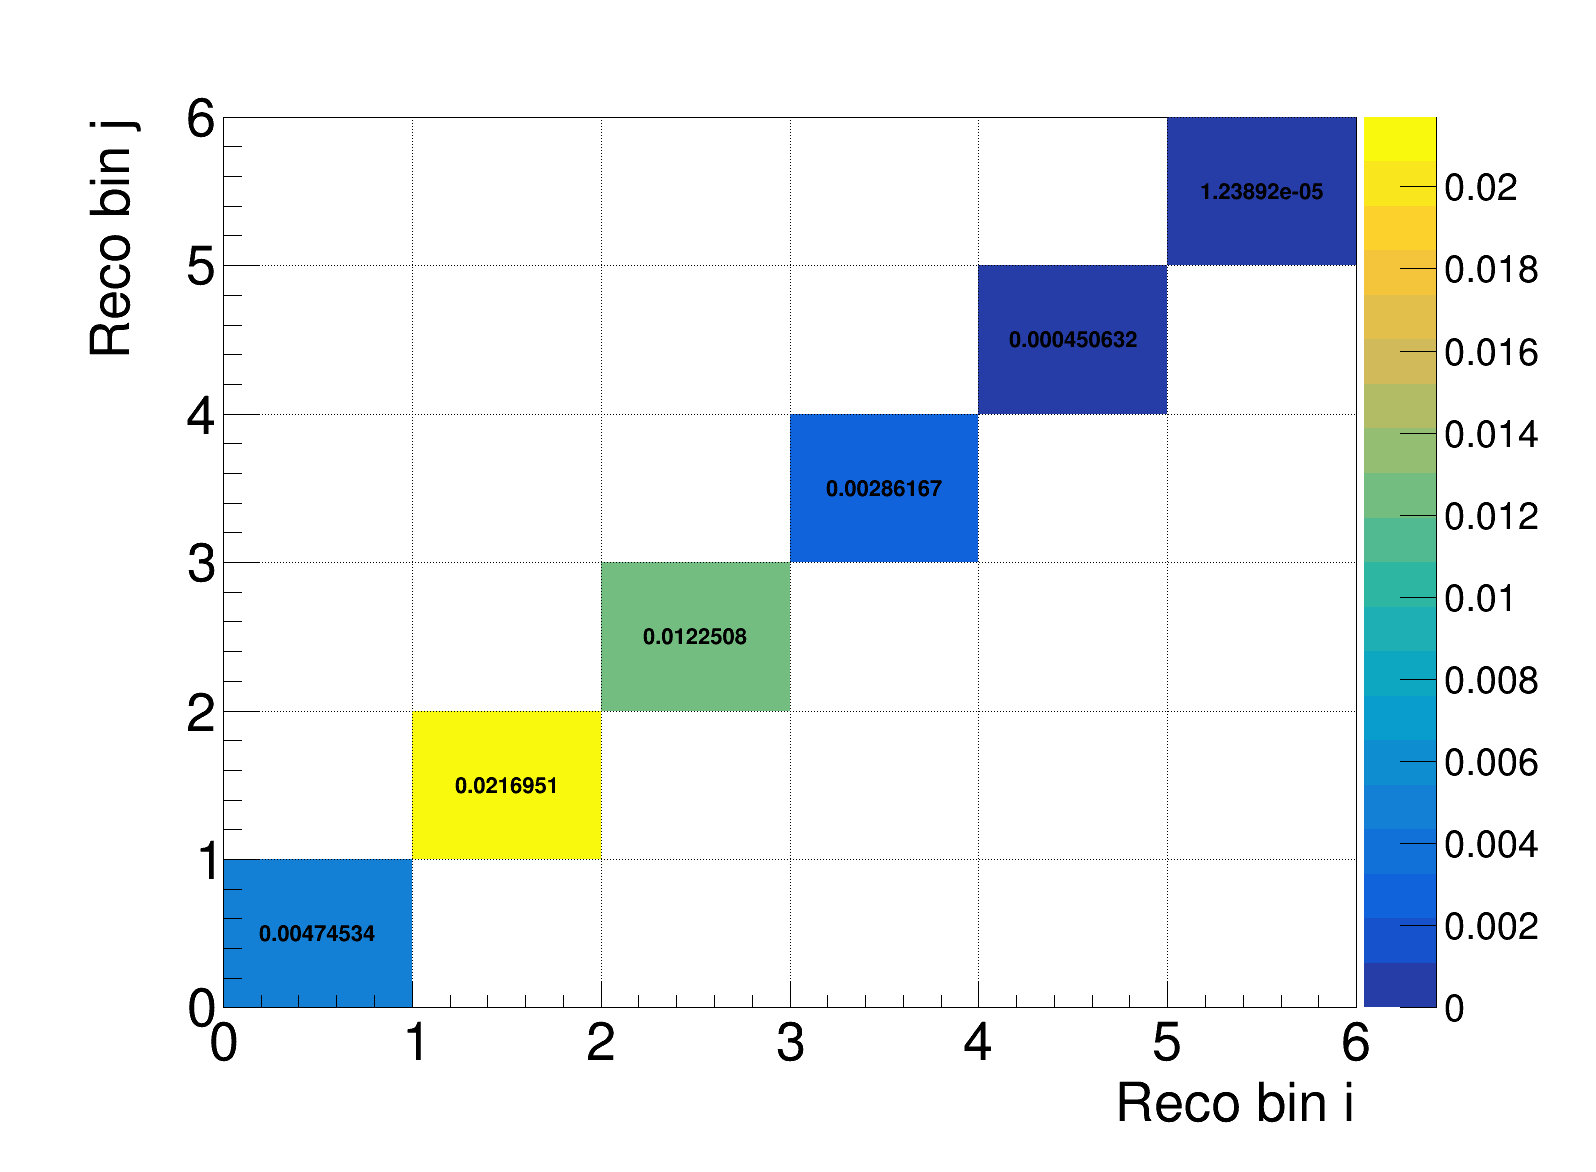

In [20]:
h_covariance_tot.Add(h_cov_stat)
h_covariance_tot.Add(h_cov_POT)

test = h_cov_stat.Clone()
test.Scale(1e76)

#test = f_flux.Get('h_frac_covariance')
test.Draw('colz')
test.Draw('Text same')
c1.Draw()

In [34]:
cov_matrix = np.zeros((6,6))
for i in range(1,7):
    for j in range(1,7):
        cov_matrix[i-1][j-1]=h_covariance_tot.GetBinContent(i,j)*1e76*1
        
        

In [35]:
'''cov_matrix = np.zeros((binnum,binnum))
for i in range(1,binnum+1):
    for j in range(1,binnum+1):
        cov_matrix[i-1][j-1]=h_cov_stat.GetBinContent(i,j)*1e76
        #print h_cov_stat.GetBinContent(i,j)*1e76
xsec_diff = np.zeros((binnum))
for i in range(1,binnum+1):
    xsec_diff[i-1] = math.sqrt(h_cov_stat.GetBinContent(i,i)*1e76)*2#+i*0.01
    #print xsec_diff[i-1]
    #print h_covariance_all_genie.GetBinContent(i,i)*1e76
cov_matrix_inv = np.linalg.inv(cov_matrix)

#print xsec_diffh_covariance_tot
#print np.transpose(xsec_diff)

chi2 = np.dot(xsec_diff,cov_matrix_inv)
chi2 = np.dot(chi2,xsec_diff)
print chi2
print np.sqrt(chi2)'''

'cov_matrix = np.zeros((binnum,binnum))\nfor i in range(1,binnum+1):\n    for j in range(1,binnum+1):\n        cov_matrix[i-1][j-1]=h_cov_stat.GetBinContent(i,j)*1e76\n        #print h_cov_stat.GetBinContent(i,j)*1e76\nxsec_diff = np.zeros((binnum))\nfor i in range(1,binnum+1):\n    xsec_diff[i-1] = math.sqrt(h_cov_stat.GetBinContent(i,i)*1e76)*2#+i*0.01\n    #print xsec_diff[i-1]\n    #print h_covariance_all_genie.GetBinContent(i,i)*1e76\ncov_matrix_inv = np.linalg.inv(cov_matrix)\n\n#print xsec_diffh_covariance_tot\n#print np.transpose(xsec_diff)\n\nchi2 = np.dot(xsec_diff,cov_matrix_inv)\nchi2 = np.dot(chi2,xsec_diff)\nprint chi2\nprint np.sqrt(chi2)'

In [36]:
'''cov_matrix = np.zeros((binnum,binnum))
for i in range(1,binnum+1):
    for j in range(1,binnum+1):
        cov_matrix[i-1][j-1]=h_covariance_all_genie.GetBinContent(i,j)*1e76
        #print h_cov_stat.GetBinContent(i,j)*1e76
xsec_diff = np.zeros((binnum))
for i in range(1,binnum+1):
    xsec_diff[i-1] = math.sqrt(h_covariance_all_genie.GetBinContent(i,i)*1e76)*1#+i*0.01
    print xsec_diff[i-1]
    #print h_covariance_all_genie.GetBinContent(i,i)*1e76
cov_matrix_inv = np.linalg.inv(cov_matrix)

#print xsec_diffh_covariance_tot
#print np.transpose(xsec_diff)

chi2 = np.dot(xsec_diff,cov_matrix_inv)
chi2 = np.dot(chi2,xsec_diff)
print chi2
print np.sqrt(chi2)'''

'cov_matrix = np.zeros((binnum,binnum))\nfor i in range(1,binnum+1):\n    for j in range(1,binnum+1):\n        cov_matrix[i-1][j-1]=h_covariance_all_genie.GetBinContent(i,j)*1e76\n        #print h_cov_stat.GetBinContent(i,j)*1e76\nxsec_diff = np.zeros((binnum))\nfor i in range(1,binnum+1):\n    xsec_diff[i-1] = math.sqrt(h_covariance_all_genie.GetBinContent(i,i)*1e76)*1#+i*0.01\n    print xsec_diff[i-1]\n    #print h_covariance_all_genie.GetBinContent(i,i)*1e76\ncov_matrix_inv = np.linalg.inv(cov_matrix)\n\n#print xsec_diffh_covariance_tot\n#print np.transpose(xsec_diff)\n\nchi2 = np.dot(xsec_diff,cov_matrix_inv)\nchi2 = np.dot(chi2,xsec_diff)\nprint chi2\nprint np.sqrt(chi2)'

In [37]:
xsec_diff = np.zeros((6))
for i in range(1,7):
    xsec_diff[i-1] = (h_xsec_data.GetBinContent(i) - h_xsec_MC.GetBinContent(i) )#*1e-38
cov_matrix_inv = np.linalg.inv(cov_matrix)

#print xsec_diffh_covariance_tot
#print np.transpose(xsec_diff)

chi2 = np.dot(xsec_diff,cov_matrix_inv)
chi2 = np.dot(chi2,xsec_diff)
print chi2
print chi2/7

59.398549375382814
8.485507053626117


In [38]:
print xsec_diff#*1e38

[-0.10023651 -0.06597799  0.1198194   0.18305969 -0.04511786 -0.02428555]


In [40]:
xsec_diff = np.zeros((6))
for i in range(1,7):
    xsec_diff[i-1] = (h_xsec_data.GetBinContent(i) - h_xsec_MC_noTune.GetBinContent(i) )#*0.5#*1e-38
cov_matrix_inv = np.linalg.inv(cov_matrix)

#print xsec_diff
#print np.transpose(xsec_diff)

chi2 = np.dot(xsec_diff,cov_matrix_inv)
chi2 = np.dot(chi2,xsec_diff)
print chi2
print chi2/7

49.21893265952525
7.031276094217893


In [27]:
print cov_matrix
print 
print cov_matrix_inv
print ''
print np.dot(cov_matrix,cov_matrix_inv)


[[4.74534114e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.16951228e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.22507827e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.86166777e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.50631974e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.23892068e-05]]

[[2.10733005e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.60933090e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.16274375e+01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.49446574e+02
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0

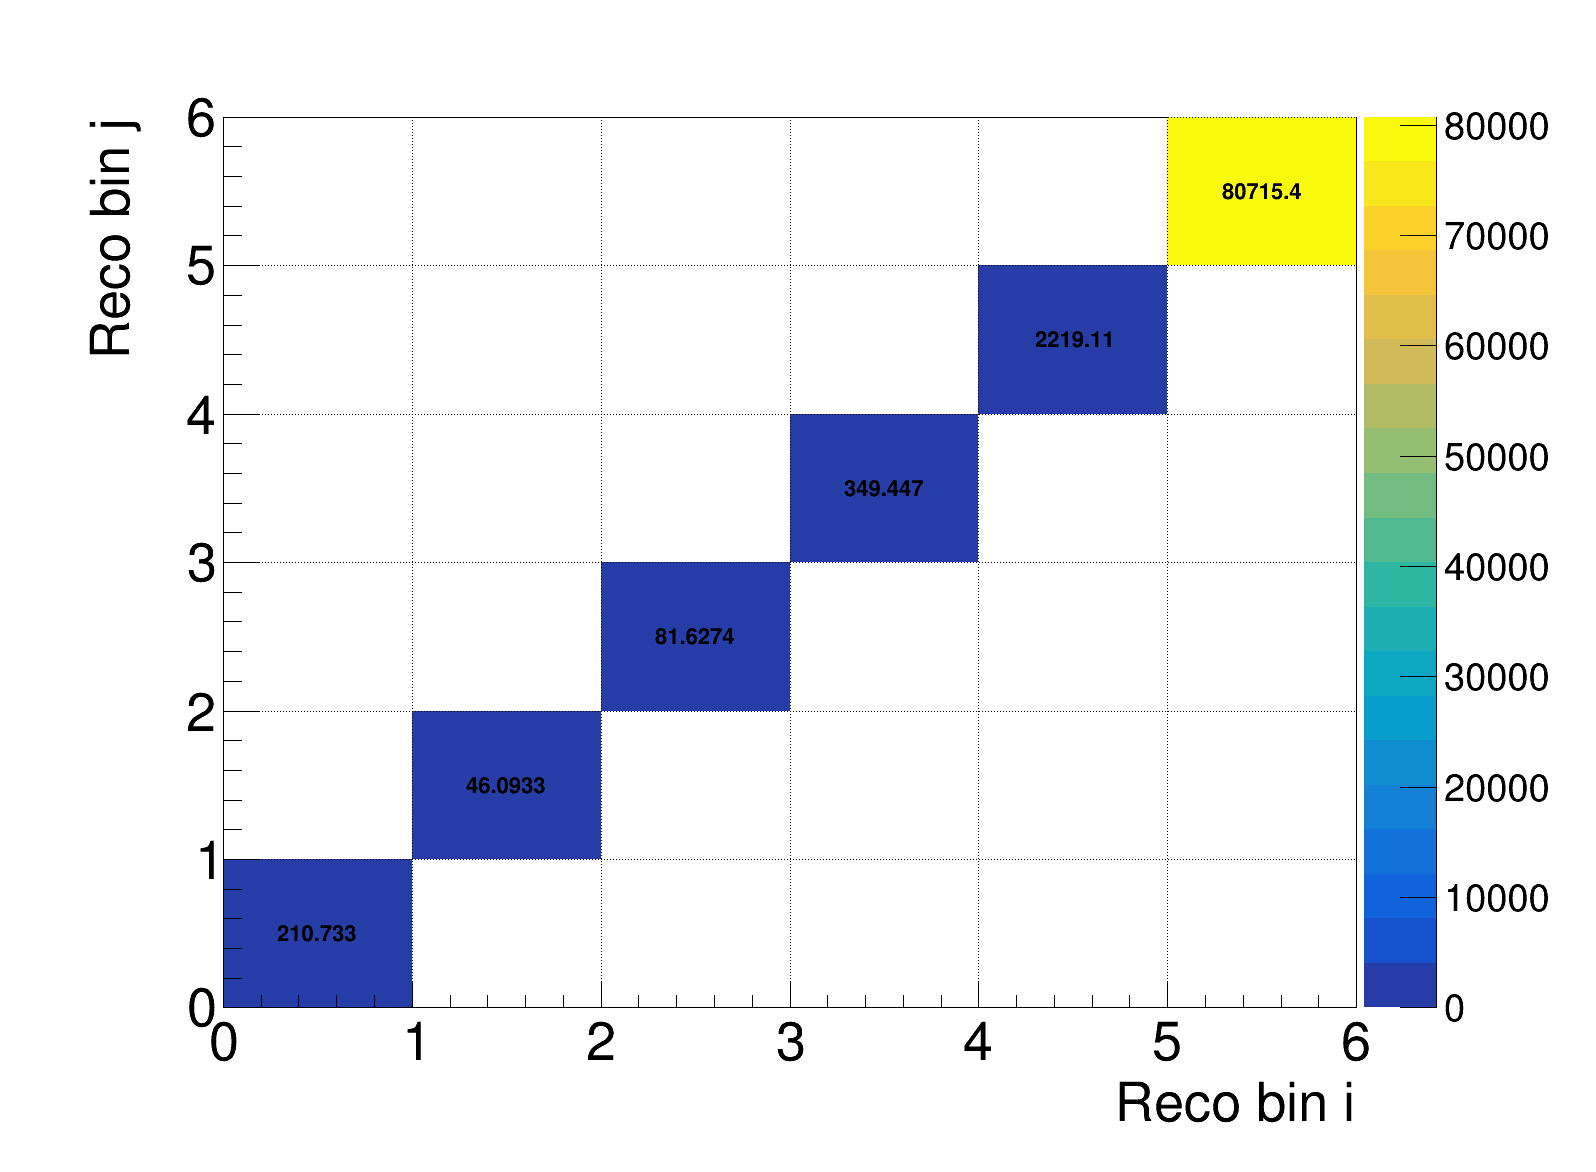

In [28]:
inv = h_covariance_tot.Clone()
for i in range(1,7):
    for j in range(1,7):
        inv.SetBinContent(i,j,cov_matrix_inv[i-1,j-1])
inv.Draw('colz')
inv.Draw('Text same')
c1.Draw()

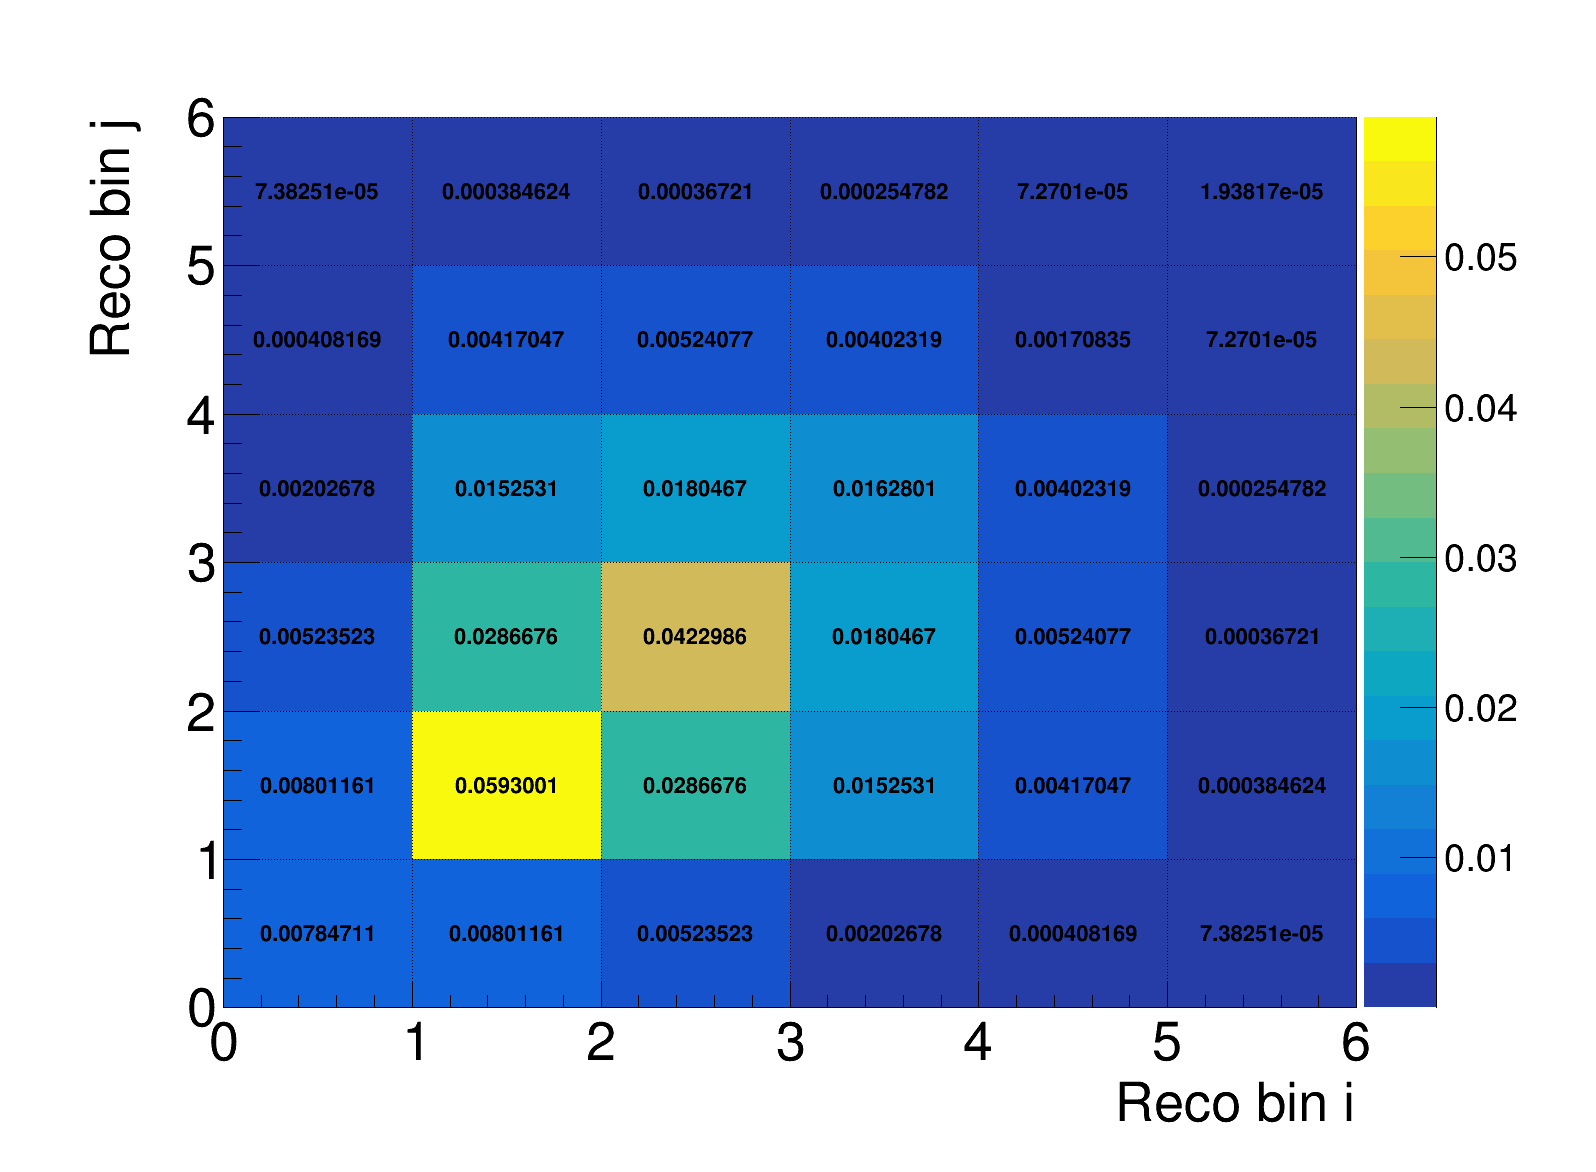

In [29]:
test = h_covariance_tot.Clone()
test.Scale(1e76)

#test = f_flux.Get('h_frac_covariance')
test.Draw('colz')
test.Draw('Text same')
c1.Draw()

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_result/png/h_xsec_corr_stat.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_result/root/h_xsec_corr_stat.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_result/pdf/h_xsec_corr_stat.pdf has been created


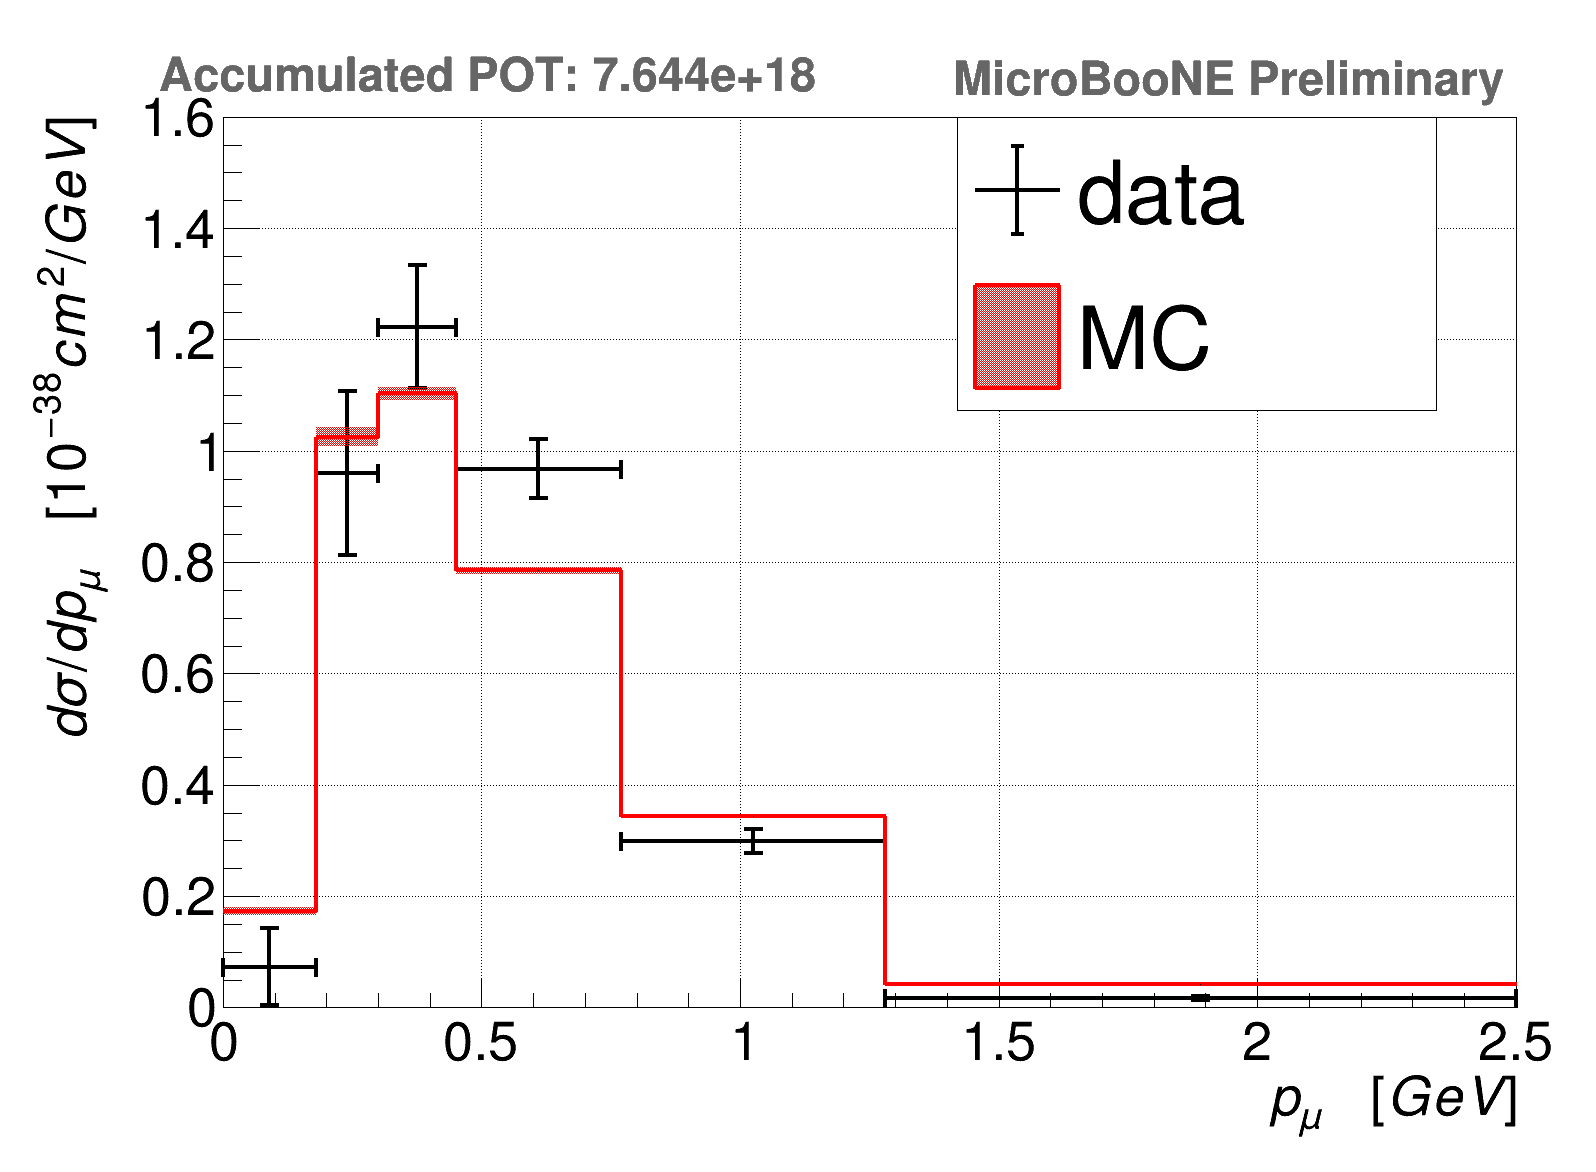

In [30]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_data,'data',"lep");
legend.AddEntry(h_xsec_MC,'MC',"f");
h_xsec_data.SetYTitle("d\sigma / dp_{\mu} \t [10^{-38} cm^{2}/GeV]")
h_xsec_data.SetXTitle("p_{\mu} \t [GeV]")
h_xsec_data.SetLineWidth(3)
h_xsec_data.SetMaximum(1.6)
h_xsec_data.SetMinimum(0)

h_xsec_data.GetYaxis().SetTitleSize(0.05)
h_xsec_data.GetYaxis().SetTitleOffset(0.0)
h_xsec_data.GetYaxis().SetLabelSize(0.05)
h_xsec_data.GetXaxis().SetTitleSize(0.05)
h_xsec_data.GetXaxis().SetLabelSize(0.05)
h_xsec_data.GetXaxis().SetTitleOffset(1)
h_xsec_data.SetLineColor(ROOT.kBlack)
h_xsec_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(9)
c1.SetRightMargin(0.05)

h_xsec_data.Draw('E1')
h_xsec_MC.SetFillColor(0)
h_xsec_MC.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC.DrawCopy('Hist same')
h_xsec_MC.SetFillColor(2)
h_xsec_MC.SetFillStyle(3001)
h_xsec_MC.Draw('E2 same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr_stat.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr_stat.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr_stat.pdf")

h_stat = h_xsec_data.Clone()

Bin  1
stat_err:  4.74534113837e-79
pot_err:  2.15920928396e-82
All_Genie:  3.9094484641e-80
genie_other_err:  7.88183444108e-81
G4_err:  1.57164142666e-81
detsys_err:  1.3774788517e-79
flux_err:  8.87628812918e-80
crt_err:  2.48625925847e-81
dirt_err:  3.24154928647e-80
all squared:  0.00784710513859
Bin  2
stat_err:  2.16951228114e-78
pot_err:  3.67948901479e-80
All_Genie:  4.96175058386e-79
genie_other_err:  1.12681669209e-79
G4_err:  7.78799406997e-81
detsys_err:  2.09711322676e-79
flux_err:  1.66569926526e-78
crt_err:  8.52605930979e-80
dirt_err:  1.14638933089e-78
all squared:  0.0593001240488
Bin  3
stat_err:  1.22507827099e-78
pot_err:  5.98086622859e-80
All_Genie:  2.23668807255e-79
genie_other_err:  9.41554754438e-80
G4_err:  9.18120953055e-82
detsys_err:  3.10228548629e-79
flux_err:  1.98650451868e-78
crt_err:  6.18333945396e-80
dirt_err:  2.67663641463e-79
all squared:  0.0422985944024
Bin  4
stat_err:  2.86166777341e-79
pot_err:  3.74783240277e-80
All_Genie:  2.54763973347

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_result/png/h_xsec_corr_allsys.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_result/root/h_xsec_corr_allsys.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_result/pdf/h_xsec_corr_allsys.pdf has been created


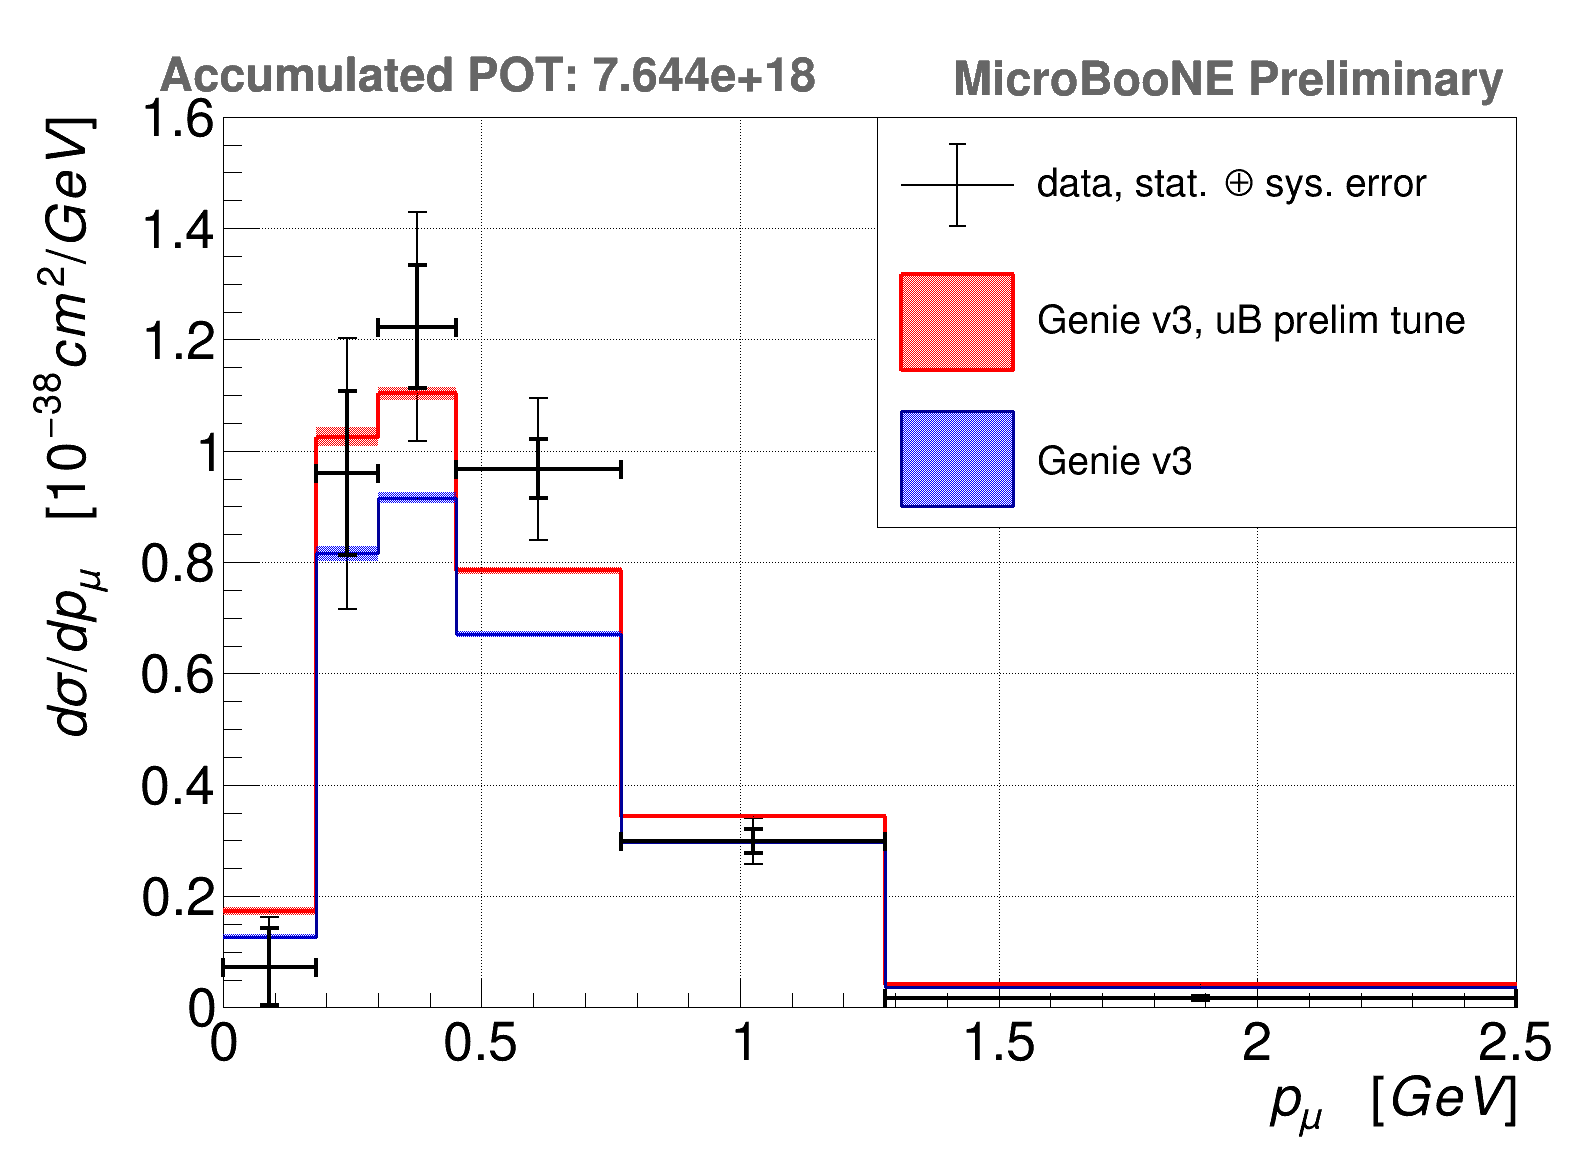

In [31]:
#all systematics
legend = ROOT.TLegend(0.55,0.55,0.95,0.9)
h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_data,'data, stat. #oplus sys. error',"lep");
legend.AddEntry(h_xsec_MC,'Genie v3, uB prelim tune',"f");
legend.AddEntry(h_xsec_MC_noTune,'Genie v3',"f");
c1.SetRightMargin(0.05)
ROOT.gStyle.SetEndErrorSize(9)

stat_err_arr = np.zeros((binnum))
pot_err_arr = np.zeros((binnum))
genie_all_err_arr = np.zeros((binnum))
genie_other_arr = np.zeros((binnum))
det_err_arr = np.zeros((binnum))
flux_err_arr = np.zeros((binnum))
crt_err_arr = np.zeros((binnum))
G4_err_arr = np.zeros((binnum))
dirt_err_arr = np.zeros((binnum))
tot_err_arr = np.zeros((binnum))


for i in range(1,binnum+1):
    stat_err = h_stat.GetBinError(i)
    stat_err = stat_err*stat_err
    pot_err = h_stat.GetBinContent(i)*0.02
    pot_err = pot_err*pot_err
    genie_all_err = h_covariance_all_genie.GetBinContent(i,i)*1e76
    genie_other_err = h_covariance_other_genie.GetBinContent(i,i)*1e76
    detsys_err = h_covariance_detsys.GetBinContent(i,i)*1e76
    flux_err = h_covariance_flux.GetBinContent(i,i)*1e76
    crt_err = h_covariance_crt.GetBinContent(i,i)*1e76
    dirt_err = h_covariance_dirt.GetBinContent(i,i)*1e76
    G4_err = h_covariance_G4.GetBinContent(i,i)*1e76
    
    stat_err_arr[i-1] = math.sqrt(stat_err)
    pot_err_arr[i-1] = math.sqrt(pot_err)
    genie_all_err_arr[i-1] = math.sqrt(genie_all_err)
    genie_other_arr[i-1] = math.sqrt(genie_other_err)
    det_err_arr[i-1] = math.sqrt(detsys_err)
    flux_err_arr[i-1] = math.sqrt(flux_err)
    crt_err_arr[i-1] = math.sqrt(crt_err)
    G4_err_arr[i-1] = math.sqrt(G4_err)
    dirt_err_arr[i-1] = math.sqrt(dirt_err)


    #G4_err = 0
    print 'Bin ',i
    print 'stat_err: ',stat_err/1e76
    print 'pot_err: ',pot_err/1e76
    print 'All_Genie: ',genie_all_err/1e76
    print 'genie_other_err: ',genie_other_err/1e76
    print 'G4_err: ',G4_err/1e76
    print 'detsys_err: ',detsys_err/1e76
    print 'flux_err: ',flux_err/1e76
    print 'crt_err: ',crt_err/1e76
    print 'dirt_err: ',dirt_err/1e76
    #print stat_err,genie_all_err,genie_other_err,detsys_err,flux_err,G4_err
    print 'all squared: ', stat_err+pot_err+genie_all_err+genie_other_err+detsys_err+flux_err+crt_err+G4_err+dirt_err
    h_xsec_data.SetBinError(i,math.sqrt(stat_err+pot_err+genie_all_err+genie_other_err+detsys_err+flux_err+crt_err+G4_err+dirt_err))
    tot_err_arr[i-1] = h_xsec_data.GetBinError(i)
    
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/stat_err_arr',stat_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/pot_err_arr',pot_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/genie_all_err_arr',genie_all_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/genie_other_arr',genie_other_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/det_err_arr',det_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/flux_err_arr',flux_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/crt_err_arr',crt_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/G4_err_arr',G4_err_arr)
np.save('/home/tmettler/Desktop/weighted/xsec_momentum_fakedata/Wes/tot_err_arr',tot_err_arr)

h_xsec_data.SetLineWidth(2)
h_xsec_data.Draw('E1')
h_xsec_MC.SetFillColor(0)
h_xsec_MC.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC.DrawCopy('Hist same')
h_xsec_MC.SetFillColor(2)
h_xsec_MC.SetFillStyle(3001)
h_xsec_MC.Draw('E2 same')

h_xsec_MC_noTune.SetFillColor(0)
h_xsec_MC_noTune.SetLineWidth(3)
#h_overlay_sig.Draw('hist same')
h_xsec_MC_noTune.DrawCopy('Hist same')
h_xsec_MC_noTune.SetFillColor(ROOT.kBlue)
h_xsec_MC_noTune.SetFillStyle(3001)
h_xsec_MC_noTune.Draw('E2 same')

h_stat.Draw('E1 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr_allsys.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr_allsys.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr_allsys.pdf")


In [32]:
res = np.zeros((6))
chi2_nom =h_xsec_data.Chi2Test(h_xsec_MC,"WW P CHI2",res)
chi2_nom =h_xsec_data.Chi2Test(h_xsec_MC_noTune,"WW P CHI2",res)


Chi2 = 36.806881, Prob = 6.54779e-07, NDF = 5, igood = 1
Chi2 = 44.319743, Prob = 1.99461e-08, NDF = 5, igood = 1


Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.



In [33]:
adsfadsf

NameError: name 'adsfadsf' is not defined

In [ ]:
#all systematics
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_MC,'Genie v3, uB prelim tune',"f");
legend.AddEntry(h_xsec_data,'data, stat. #oplus sys. error',"lep");
c1.SetRightMargin(0.05)
ROOT.gStyle.SetEndErrorSize(9)
for i in range(1,binnum+1):
    stat_err = h_stat.GetBinError(i)
    stat_err = stat_err*stat_err
    pot_err = h_stat.GetBinContent(i)*0.02
    pot_err = pot_err*pot_err
    genie_all_err = h_covariance_all_genie.GetBinContent(i,i)*1e76
    genie_other_err = h_covariance_other_genie.GetBinContent(i,i)*1e76
    detsys_err = h_covariance_detsys.GetBinContent(i,i)*1e76
    flux_err = h_covariance_flux.GetBinContent(i,i)*1e76
    crt_err = h_covariance_crt.GetBinContent(i,i)*1e76
    G4_err = h_covariance_G4.GetBinContent(i,i)*1e76
    dirt_err = h_covariance_dirt.GetBinContent(i,i)*1e76
    #G4_err = 0
    print 'Bin ',i
    print 'stat_err: ',stat_err/1e76
    print 'pot_err: ',pot_err/1e76
    print 'All_Genie: ',genie_all_err/1e76
    print 'genie_other_err: ',genie_other_err/1e76
    print 'G4_err: ',G4_err/1e76
    print 'detsys_err: ',detsys_err/1e76
    print 'flux_err: ',flux_err/1e76
    print 'crt_err: ',crt_err/1e76
    #print stat_err,genie_all_err,genie_other_err,detsys_err,flux_err,G4_err
    
    h_xsec_data.SetBinError(i,math.sqrt(0*stat_err+pot_err+genie_all_err+genie_other_err+detsys_err+flux_err+crt_err+G4_err+dirt_err))

h_xsec_data.SetLineWidth(2)
h_xsec_data.Draw('E1')
h_xsec_MC.SetFillColor(0)
h_xsec_MC.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC.DrawCopy('Hist same')
h_xsec_MC.SetFillColor(2)
h_xsec_MC.SetFillStyle(3001)
h_xsec_MC.Draw('E2 same')
#h_stat.Draw('E1 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_sys_only.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_sys_only.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_sys_only.pdf")


In [ ]:
#all systematics
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
h_xsec_MC.SetLineColor(2)
legend.AddEntry(h_xsec_data,'data, stat. #oplus sys. error',"lep");
legend.AddEntry(h_xsec_MC,'Genie v3, uB prelim tune',"f");

c1.SetRightMargin(0.05)
ROOT.gStyle.SetEndErrorSize(9)
mcc8_y = [0.03023, 0.73027, 1.12572, 0.81047, 0.29213, 0.01813]
mcc8_e1 = [0.08465, 1.0102, 1.41943, 0.97098, 0.35152, 0.02659]
#mcc8_e2 = [0.07416, 0.74558, 1.13744, 0.83391, 0.33245, 0.06538]
h_mcc8 = h_stat.Clone()
h_mcc8.SetLineColor(ROOT.kGreen)
legend.AddEntry(h_mcc8,'mcc8, stat. #oplus sys. error',"lep");
mcc8_genie = [0.11151, 1.0762, 1.23294, 0.86047, 0.38807, 0.05309]
h_mcc8_genie = h_stat.Clone()
legend.AddEntry(h_mcc8_genie,'MC, MCC8',"f");
for i in range(1,binnum+1):
    h_mcc8.SetBinContent(i,mcc8_y[i-1])
    h_mcc8.SetBinError(i,mcc8_e1[i-1] - mcc8_y[i-1])
    h_mcc8_genie.SetBinContent(i,mcc8_genie[i-1])

    stat_err = h_stat.GetBinError(i)
    stat_err = stat_err*stat_err
    pot_err = h_stat.GetBinContent(i)*0.02
    pot_err = pot_err*pot_err
    genie_all_err = h_covariance_all_genie.GetBinContent(i,i)*1e76
    genie_other_err = h_covariance_other_genie.GetBinContent(i,i)*1e76
    detsys_err = h_covariance_detsys.GetBinContent(i,i)*1e76
    flux_err = h_covariance_flux.GetBinContent(i,i)*1e76
    crt_err = h_covariance_crt.GetBinContent(i,i)*1e76
    G4_err = h_covariance_G4.GetBinContent(i,i)*1e76
    dirt_err = h_covariance_dirt.GetBinContent(i,i)*1e76

    h_xsec_data.SetBinError(i,math.sqrt(stat_err+pot_err+genie_all_err+genie_other_err+detsys_err+flux_err+crt_err+G4_err+dirt_err))

h_xsec_data.SetLineWidth(4)
h_xsec_data.SetMarkerStyle(4)
h_xsec_data.SetMarkerSize(2)
h_xsec_data.Draw('E1')

h_xsec_MC.SetFillColor(0)
h_xsec_MC.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_xsec_MC.Draw('Hist same')
#h_xsec_MC.SetFillColor(2)
#h_xsec_MC.SetFillStyle(3001)
#h_xsec_MC.Draw('E2 same')
#h_stat.Draw('E1 same')
h_mcc8.SetLineColor(ROOT.kBlue)
h_mcc8.SetMarkerColor(ROOT.kBlue)
h_mcc8.SetLineWidth(2)
h_mcc8.SetMarkerStyle(4)
h_mcc8.SetMarkerSize(2)
h_mcc8.Draw('E1 same')

h_mcc8_genie.SetLineColor(ROOT.kGreen)
h_mcc8_genie.SetLineWidth(2)
h_mcc8_genie.Draw('Hist same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_comp.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_comp.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_comp.pdf")


In [ ]:
#make plots with results of MCC8

In [ ]:
#8.004594109042256e-39+/-3.0460599676519193e-40

In [ ]:
h_tot_xsec = ROOT.TH1F('h_tot_xsec','h_tot_xsec',2,0,1)
c1.SetRightMargin(0.05)
xsec_mcc9 = 8.004594109042256e-39*1e38
stat_err_9 = 3.0460599676519193e-40*1e38
sys_err_9_frac = 0.1268#0.1166#0.1490434 # 0.1166
sys_err_9 = xsec_mcc9*sys_err_9_frac


xsec_mcc8 = 0.693e-38*1e38
stat_err_8 = 0.010e-38*1e38
sys_err_8 = 0.165e-38*1e38
h_tot_xsec.SetBinContent(1,xsec_mcc9)
h_tot_xsec.SetBinError(1,math.sqrt(stat_err_9*stat_err_9+sys_err_9*sys_err_9) )
h_tot_xsec.SetBinContent(2,xsec_mcc8)
h_tot_xsec.SetBinError(2,math.sqrt(stat_err_8*stat_err_8+sys_err_8*sys_err_8) )
h_tot_xsec.SetLineColor(ROOT.kBlack), h_tot_xsec.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(9)
h_tot_xsec_stat = h_tot_xsec.Clone()
h_tot_xsec_stat.SetBinError(1,stat_err_9 )
h_tot_xsec_stat.SetBinError(2,stat_err_8 )
h_tot_xsec_stat.SetLineColor(ROOT.kRed+2)

h_tot_xsec_sys = h_tot_xsec.Clone()
h_tot_xsec_sys.SetBinError(1,sys_err_9 )
h_tot_xsec_sys.SetBinError(2,sys_err_8 )
h_tot_xsec_sys.SetLineColor(ROOT.kBlue+2)

h_tot_MC = ROOT.TH1F('h_tot_MC','h_tot_MC',2,0,1)
xsec_MC_9 = 0.801
xsec_MC_8 = 0.871
h_tot_MC.SetBinContent(1,xsec_MC_9)
h_tot_MC.SetBinContent(2,xsec_MC_9)
h_tot_MC_8 = ROOT.TH1F('h_tot_MC_8','h_tot_MC_8',2,0,1)
h_tot_MC_8.SetBinContent(1,xsec_MC_8)
h_tot_MC_8.SetBinContent(2,xsec_MC_8)

h_tot_MC.SetLineColor(ROOT.kBlue)
h_tot_MC.SetLineWidth(4)
h_tot_MC_8.SetLineColor(ROOT.kGreen)
h_tot_MC_8.SetLineWidth(4)

h_tot_xsec.SetMaximum(h_tot_xsec.GetMaximum()*1.5)

legend = ROOT.TLegend(0.55,0.6,0.9,0.9) # LEGEND LEFT
legend.AddEntry(h_tot_xsec,"\sigma, stat. \oplus sys. error","lep");
legend.AddEntry(h_tot_xsec_stat,"\sigma, stat. error","lep");
legend.AddEntry(h_tot_MC,"Genie v3, uB prelim tune","l");
legend.AddEntry(h_tot_MC_8,"MCC8 MC","l");

h_tot_xsec.GetYaxis().SetTitleSize(0.05)
h_tot_xsec.GetYaxis().SetTitleOffset(0.0)
h_tot_xsec.GetYaxis().SetLabelSize(0.05)

h_tot_xsec.GetXaxis().SetTitleSize(0.15)
h_tot_xsec.GetXaxis().SetLabelSize(0.15)
h_tot_xsec.GetXaxis().SetTitleOffset(-999)
h_tot_xsec.GetXaxis().SetLabelOffset(0.02)
h_tot_xsec.GetXaxis().SetLabelSize(0.15)
h_tot_xsec.SetYTitle("\sigma  \t [10^{-38} cm^{2}]")
h_tot_xsec.GetXaxis().SetBinLabel(1, 'MCC9')
h_tot_xsec.GetXaxis().SetBinLabel(2, 'MCC8')
h_tot_xsec.Draw('E1')
#h_tot_xsec_sys.Draw('E1 same')
h_tot_MC.Draw('hist same')
h_tot_MC_8.Draw('hist same')
h_tot_xsec.Draw('E1 same')
h_tot_xsec_stat.Draw('E1 same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_xsec_MCC8_comparison.png")
c1.SaveAs(outputdir_root + "h_xsec_MCC8_comparison.root")
c1.SaveAs(outputdir_pdf + "h_xsec_MCC8_comparison.pdf")

In [ ]:
h_tot_xsec = ROOT.TH1F('h_tot_xsec','h_tot_xsec',2,0,1)
c1.SetRightMargin(0.05)
xsec_mcc9 = 8.004594109042256e-39*1e38
stat_err_9 = 3.0460599676519193e-40*1e38
sys_err_9_frac = 0.1268 #0.1490434 # 0.1166
sys_err_9 = xsec_mcc9*sys_err_9_frac


xsec_mcc8 = 0.693e-38*1e38
stat_err_8 = 0.010e-38*1e38
sys_err_8 = 0.165e-38*1e38
h_tot_xsec.SetBinContent(1,xsec_mcc9)
h_tot_xsec.SetBinError(1,math.sqrt(stat_err_9*stat_err_9+sys_err_9*sys_err_9) )
h_tot_xsec.SetBinContent(2,xsec_mcc8)
h_tot_xsec.SetBinError(2,math.sqrt(stat_err_8*stat_err_8+sys_err_8*sys_err_8) )
h_tot_xsec.SetLineColor(ROOT.kBlack), h_tot_xsec.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(9)
h_tot_xsec_stat = h_tot_xsec.Clone()
h_tot_xsec_stat.SetBinError(1,stat_err_9 )
h_tot_xsec_stat.SetBinError(2,stat_err_8 )
h_tot_xsec_stat.SetLineColor(ROOT.kRed+2)

h_tot_xsec_sys = h_tot_xsec.Clone()
h_tot_xsec_sys.SetBinError(1,sys_err_9 )
h_tot_xsec_sys.SetBinError(2,sys_err_8 )
h_tot_xsec_sys.SetLineColor(ROOT.kBlue+2)

h_tot_MC = ROOT.TH1F('h_tot_MC','h_tot_MC',2,0,1)
xsec_MC_9 = 0.801
xsec_MC_8 = 0.871
h_tot_MC.SetBinContent(1,xsec_MC_9)
h_tot_MC.SetBinContent(2,xsec_MC_9)
h_tot_MC_8 = ROOT.TH1F('h_tot_MC_8','h_tot_MC_8',2,0,1)
h_tot_MC_8.SetBinContent(1,xsec_MC_8)
h_tot_MC_8.SetBinContent(2,xsec_MC_8)

h_tot_MC.SetLineColor(ROOT.kBlue)
h_tot_MC.SetLineWidth(4)
h_tot_MC_8.SetLineColor(ROOT.kGreen)
h_tot_MC_8.SetLineWidth(4)

h_tot_xsec.SetMaximum(h_tot_xsec.GetMaximum()*1.5)

legend = ROOT.TLegend(0.59,0.7,0.95,0.9) # LEGEND LEFT
legend.AddEntry(h_tot_xsec,"\sigma, stat. \oplus sys. error","lep");
legend.AddEntry(h_tot_xsec_stat,"\sigma, stat. error","lep");
legend.AddEntry(h_tot_MC,"Genie v3, uB prelim tune","l");
legend.AddEntry(h_tot_MC_8,"previous MC","l");

h_tot_xsec.GetYaxis().SetTitleSize(0.05)
h_tot_xsec.GetYaxis().SetTitleOffset(0.0)
h_tot_xsec.GetYaxis().SetLabelSize(0.05)

h_tot_xsec.GetXaxis().SetTitleSize(0.15)
h_tot_xsec.GetXaxis().SetLabelSize(0.15)
h_tot_xsec.GetXaxis().SetTitleOffset(-999)
h_tot_xsec.GetXaxis().SetLabelOffset(0.02)
h_tot_xsec.GetXaxis().SetLabelSize(0.1)
h_tot_xsec.SetYTitle("\sigma  \t [10^{-38} cm^{2}]")
h_tot_xsec.GetXaxis().SetBinLabel(1, 'this work')
h_tot_xsec.GetXaxis().SetBinLabel(2, 'previous work')
h_tot_xsec.Draw('E1')
#h_tot_xsec_sys.Draw('E1 same')
h_tot_MC.Draw('hist same')
h_tot_MC_8.Draw('hist same')
h_tot_xsec.Draw('E1 same')
h_tot_xsec_stat.Draw('E1 same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_xsec_MCC8_comparison_pub.png")
c1.SaveAs(outputdir_root + "h_xsec_MCC8_comparison_pub.root")
c1.SaveAs(outputdir_pdf + "h_xsec_MCC8_comparison_pub.pdf")